## 3. ML Modeling

- In this notebook, we will illustrate how to train an XGBoost model with the diamonds dataset using [OSS XGBoost](https://xgboost.readthedocs.io/en). 
- We also show how to do inference and manage models via Model Registry.

### Import Libraries

In [1]:
# !pip install shap

In [2]:
# [MB] To setup explicit connection
import os
from dotenv import load_dotenv
from snowflake.snowpark import Session

# Snowpark for Python
# import snowflake.snowpark.functions as F
from snowflake.snowpark.version import VERSION

# Snowflake ML
from snowflake.ml.registry import Registry
from snowflake.ml._internal.utils import identifier

# Data science libs
# import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error

# Misc
# import json
import joblib
import warnings
# import cachetools

# Warning suppression
warnings.simplefilter('ignore')

In [3]:
# [MB] Load environment variables
load_dotenv()
USER = os.getenv('SNOWSQL_USER')
ACCOUNT = os.getenv('SNOWSQL_ACCOUNT')
PASSWORD = os.getenv('SNOWSQL_PWD')

In [4]:
# [MB] Can't run SQL inside Jupyter notebook. Instead set in following cell.
# -- Using Warehouse, Database, and Schema created during Setup
# USE WAREHOUSE ML_HOL_WH;
# USE DATABASE ML_HOL_DB;
# USE SCHEMA ML_HOL_SCHEMA;

In [5]:
# [MB] Create a Snowpark session explicitly
connection_parameters = {
    "account": ACCOUNT,
    "user": USER,
    "password": PASSWORD,
    "role": "ML_MODEL_HOL_USER",
    "warehouse": "ML_HOL_WH",
    "database": "ML_HOL_DB",
    "schema": "ML_HOL_SCHEMA"
}
session = Session.builder.configs(connection_parameters).create()

# Establish Secure Connection to Snowflake
# session = get_active_session()

# Add a query tag to the session.
# session.query_tag = {
#     "origin": "sf_sit-is",
#     "name": "e2e_ml_snowparkpython",
#     "version": {"major": 1, "minor": 0,},
#     "attributes":{"is_quickstart":1}
# }
session

### Load the data & preprocessing pipeline

In [6]:
# Load in the data
diamonds_df = session.table("DIAMONDS")
# diamonds_df.show()
diamonds_df.to_pandas()

,COLOR,CLARITY,PRICE,CUT,CARAT,X,Y,Z,DEPTH,TABLE_PCT
0,E,SI2,326,IDEAL,0.23,3.95,3.98,2.43,61.5,55.0
1,E,SI1,326,PREMIUM,0.21,3.89,3.84,2.31,59.8,61.0
2,E,VS1,327,GOOD,0.23,4.05,4.07,2.31,56.9,65.0
3,I,VS2,334,PREMIUM,0.29,4.20,4.23,2.63,62.4,58.0
4,J,SI2,335,GOOD,0.31,4.34,4.35,2.75,63.3,58.0
...,...,...,...,...,...,...,...,...,...,...
53935,D,SI1,2757,IDEAL,0.72,5.75,5.76,3.50,60.8,57.0
53936,D,SI1,2757,GOOD,0.72,5.69,5.75,3.61,63.1,55.0
53937,D,SI1,2757,VERY_GOOD,0.70,5.66,5.68,3.56,62.8,60.0
53938,H,SI2,2757,PREMIUM,0.86,6.15,6.12,3.74,61.0,58.0


In [7]:
# Categorize all the features for modeling
CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = ["CUT_OE", "COLOR_OE", "CLARITY_OE"]  # Ord. encoded
NUMERICAL_COLUMNS = ["CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]

LABEL_COLUMNS = ['PRICE']
OUTPUT_COLUMNS = ['PREDICTED_PRICE']

In [8]:
# Load the preprocessing pipeline object from stage:
# download the preprocessing_pipeline.joblib.gz file to the warehouse
# where our notebook is running, and then load it using joblib.
session.file.get('@ML_HOL_ASSETS/preprocessing_pipeline.joblib.gz', '/tmp')
PIPELINE_FILE = '/tmp/preprocessing_pipeline.joblib.gz'
preprocessing_pipeline = joblib.load(PIPELINE_FILE)

### Build a simple open-source XGBoost Regression model

In [9]:
# Split the data into train and test sets
diamonds_train_df, diamonds_test_df = diamonds_df.random_split(
    weights=[0.9, 0.1],
    seed=0
)

# Run the train and test sets through the Pipeline object we defined earlier
train_df = preprocessing_pipeline.fit(
    diamonds_train_df
).transform(diamonds_train_df)
test_df = preprocessing_pipeline.transform(diamonds_test_df)

# Convert to pandas dataframes to use OSS XGBoost
ALL_COLUMNS = CATEGORICAL_COLUMNS_OE + NUMERICAL_COLUMNS + LABEL_COLUMNS
train_pd = train_df.select(ALL_COLUMNS).to_pandas()
test_pd = test_df.select(ALL_COLUMNS).to_pandas()

In [10]:
# Define model config
regressor = XGBRegressor()

# Split train data into X, y
y_train_pd = train_pd.PRICE
X_train_pd = train_pd.drop(columns=['PRICE'])

# Train model
regressor.fit(X_train_pd, y_train_pd)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [11]:
# We can now get predictions
y_test_pred = regressor.predict(test_pd.drop(columns=['PRICE']))
y_train_pred = regressor.predict(train_pd.drop(columns=['PRICE']))

Let's analyze the results using Snowflake ML's MAPE.

In [12]:
mape = mean_absolute_percentage_error(y_train_pd, y_train_pred)

In [13]:
print(f"Mean absolute percentage error: {mape}")

Mean absolute percentage error: 0.06424203515052795


### Now, let's use `scikit-learn`'s `GridSearchCV` function to find optimal model parameters

In [14]:
param_grid = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.1, 0.4]
}

xgb = XGBRegressor()
clf = GridSearchCV(xgb, param_grid)
clf.fit(X_train_pd, y_train_pd)

,estimator,"XGBRegressor(...ate=None, ...)"
,param_grid,"{'learning_rate': [0.1, 0.4], 'n_estimators': [100, 200, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [15]:
print(clf.best_estimator_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


We see that the best estimator has the following parameters: `n_estimators=500` & `learning_rate=0.4`.

We can also analyze the full grid search results.

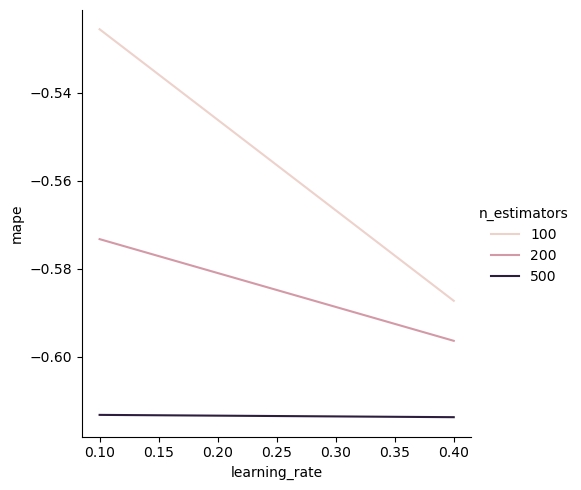

In [16]:
# Analyze grid search results
gs_results = clf.cv_results_
n_estimators_val = []
learning_rate_val = []

for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])

mape_val = gs_results["mean_test_score"] * -1

gs_results_df = pd.DataFrame(data={
    "n_estimators": n_estimators_val,
    "learning_rate": learning_rate_val,
    "mape": mape_val
})

sns.relplot(
    data=gs_results_df,
    x="learning_rate",
    y="mape",
    hue="n_estimators",
    kind="line"
)
plt.show()

This is consistent with the `learning_rate=0.4` and `n_estimator=500` chosen as the best estimator with the lowest MAPE.

Now, let's predict and analyze the results from using the best estimator.

In [17]:
# Predict
opt_model = clf.best_estimator_
y_train_pred = opt_model.predict(train_pd.drop(columns=['PRICE']))

mape = mean_absolute_percentage_error(y_train_pd, y_train_pred)

print(f"Mean absolute percentage error: {mape}")

Mean absolute percentage error: 0.04436366260051727


Let's save our optimal model and its metadata:


In [18]:
optimal_model = clf.best_estimator_
optimal_n_estimators = clf.best_estimator_.n_estimators
optimal_learning_rate = clf.best_estimator_.learning_rate

optimal_mape = gs_results_df.loc[
    (gs_results_df['n_estimators'] == optimal_n_estimators) &
    (gs_results_df['learning_rate'] == optimal_learning_rate),
    'mape'
].values[0]  # type: ignore
optimal_mape

np.float64(-0.6138019919395447)

### Manage models using Model Registry

Now, with Snowflake ML's [Model Registry](https://docs.snowflake.com/en/developer-guide/snowpark-ml/snowpark-ml-mlops-model-registry), we have a Snowflake native model versioning and deployment framework. This allows us to log models, tag parameters and metrics, track metadata, create versions, and ultimately execute batch inference tasks in a Snowflake warehouse or deploy to a Snowpark Container Service.

First, we will log our models.

Refer to [this Medium post](https://medium.com/snowflake/whats-in-a-name-model-naming-versioning-in-snowpark-model-registry-b5f7105fd6f6) on best practices for model naming & versioning conventions.

In [21]:
# Get sample input data to pass into the registry logging function
X = train_df.select(CATEGORICAL_COLUMNS_OE + NUMERICAL_COLUMNS).limit(100)

db = identifier._get_unescaped_name(
    session.get_current_database()  # type: ignore
)
schema = identifier._get_unescaped_name(
    session.get_current_schema()  # type: ignore
)

# Define model name
model_name = "DIAMONDS_PRICE_PREDICTION"

# Create a registry and log the model
native_registry = Registry(
    session=session,
    database_name=db,
    schema_name=schema
)

# Let's first log the very first model we trained
model_ver = native_registry.log_model(
    model_name=model_name,
    version_name='V2',
    model=regressor,
    sample_input_data=X,  # to provide the feature schema
    target_platforms={'WAREHOUSE'}  # type: ignore
)

# Add evaluation metric
model_ver.set_metric(metric_name="mean_abs_pct_err", value=mape)

# Add a description
model_ver.comment = (
    "This is the first iteration of our Diamonds Price Prediction model." +
    "It is used for demo purposes."
)

# Now, let's log the optimal model from GridSearchCV
model_ver2 = native_registry.log_model(
    model_name=model_name,
    version_name='V3',
    model=optimal_model,
    sample_input_data=X,  # to provide the feature schema
    target_platforms={'WAREHOUSE'}  # type: ignore
)

# Add evaluation metric
model_ver2.set_metric(metric_name="mean_abs_pct_err", value=optimal_mape)

# Add a description
model_ver2.comment = (
    "This is the second iteration of our Diamonds Price Prediction model " +
    "where we performed hyperparameter optimization. " +
    "Optimal n_estimators & learning_rate: " +
    f"{optimal_n_estimators}, {optimal_learning_rate}"
)

Model logged successfully.: 100%|██████████| 6/6 [00:23<00:00,  3.86s/it]                          


In [22]:
# Let's confirm they were added
native_registry.get_model(model_name).show_versions()

,created_on,name,aliases,comment,database_name,schema_name,model_name,is_default_version,functions,metadata,user_data,model_attributes,size,environment,runnable_in,inference_services
0,2025-10-01 18:17:12.156000-07:00,V0,"[""DEFAULT"",""FIRST""]",This is the first iteration of our Diamonds Pr...,ML_HOL_DB,ML_HOL_SCHEMA,DIAMONDS_PRICE_PREDICTION,true,"[""EXPLAIN"",""PREDICT""]","{""metrics"": {""mean_abs_pct_err"": 0.04436366260...",{},"{""framework"":""xgboost"",""task"":""TABULAR_REGRESS...",6820986,"{""default"":{""python_version"":""3.11"",""cuda_vers...","[""WAREHOUSE""]",[]
1,2025-10-01 18:17:35.786000-07:00,V1,[],This is the second iteration of our Diamonds P...,ML_HOL_DB,ML_HOL_SCHEMA,DIAMONDS_PRICE_PREDICTION,false,"[""EXPLAIN"",""PREDICT""]","{""metrics"": {""mean_abs_pct_err"": -0.6138019919...",{},"{""framework"":""xgboost"",""task"":""TABULAR_REGRESS...",8562411,"{""default"":{""python_version"":""3.11"",""cuda_vers...","[""WAREHOUSE""]",[]
2,2025-10-09 07:24:56.957000-07:00,V2,[],This is the first iteration of our Diamonds Pr...,ML_HOL_DB,ML_HOL_SCHEMA,DIAMONDS_PRICE_PREDICTION,false,"[""EXPLAIN"",""PREDICT""]","{""metrics"": {""mean_abs_pct_err"": 0.04436366260...",{},"{""framework"":""xgboost"",""task"":""TABULAR_REGRESS...",6834776,"{""default"":{""python_version"":""3.12"",""cuda_vers...","[""WAREHOUSE""]",[]
3,2025-10-09 07:25:20.824000-07:00,V3,"[""LAST""]",This is the second iteration of our Diamonds P...,ML_HOL_DB,ML_HOL_SCHEMA,DIAMONDS_PRICE_PREDICTION,false,"[""EXPLAIN"",""PREDICT""]","{""metrics"": {""mean_abs_pct_err"": -0.6138019919...",{},"{""framework"":""xgboost"",""task"":""TABULAR_REGRESS...",8576201,"{""default"":{""python_version"":""3.12"",""cuda_vers...","[""WAREHOUSE""]",[]


We can see what the default model is when we have multiple versions with the same model name:


In [23]:
native_registry.get_model(model_name).default.version_name

'V0'

Now we can use the optimal model to perform inference.

In [24]:
model_ver = native_registry.get_model(model_name).version('v1')
result_sdf2 = model_ver.run(test_df, function_name="predict")
# result_sdf2.show()
result_sdf2.to_pandas()  # type: ignore

,CARAT,DEPTH,TABLE_PCT,X,Y,Z,CUT_OE,COLOR_OE,CLARITY_OE,COLOR,CLARITY,PRICE,CUT,output_feature_0
0,0.103950,0.516667,0.250000,0.530726,0.096265,0.110063,0.0,3.0,4.0,G,VS2,2757,IDEAL,2716.864502
1,0.106029,0.450000,0.346154,0.540037,0.099830,0.108805,3.0,1.0,4.0,E,VS2,2772,GOOD,2965.878174
2,0.106029,0.522222,0.307692,0.530726,0.097623,0.111321,1.0,1.0,5.0,E,SI1,2792,PREMIUM,2724.507080
3,0.110187,0.541667,0.269231,0.535382,0.096774,0.112579,1.0,2.0,4.0,F,VS2,2805,PREMIUM,2658.667969
4,0.103950,0.522222,0.326923,0.529795,0.095756,0.110063,1.0,2.0,4.0,F,VS2,2818,PREMIUM,2638.425049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5407,0.126819,0.480556,0.288462,0.558659,0.102547,0.114151,2.0,5.0,5.0,I,SI1,2701,VERY_GOOD,2521.249023
5408,0.106029,0.519444,0.250000,0.532588,0.096604,0.110692,0.0,1.0,5.0,E,SI1,2704,IDEAL,2795.072021
5409,0.106029,0.530556,0.307692,0.528864,0.097114,0.111321,1.0,1.0,4.0,E,VS2,2711,PREMIUM,2873.389160
5410,0.112266,0.447222,0.326923,0.547486,0.100679,0.109748,2.0,1.0,6.0,E,SI2,2728,VERY_GOOD,2352.864258


You can also execute inference using SQL. To do this, we will use a SQL cell and reference our model's predict method via the model object's name.

In [25]:
test_df.write.mode('overwrite').save_as_table('DIAMONDS_TEST')

In [26]:
# [MB] TODO: execute SQL-based prediction in an SQL script
# --- For any other version (for example V1 below):
# WITH model_version_alias AS MODEL DIAMONDS_PRICE_PREDICTION VERSION v1 (
#     SELECT a.*, model_version_alias!predict(
#         a.CUT_OE,
#         a.COLOR_OE,
#         a.CLARITY_OE,
#         a.CARAT,
#         a.DEPTH,
#         a.TABLE_PCT,
#         a.X,
#         a.Y,
#         a.Z
#     )['output_feature_0'] as prediction FROM DIAMONDS_TEST a
# )

### Model Explainability

Another thing we may want to look at to better understand the predictions are explanations on what the model considers most impactful when generating the predictions. To generate these explanations, we'll use the [built-in explainability function](https://docs.snowflake.com/en/developer-guide/snowflake-ml/model-registry/model-explainability) from Snowflake ML. 

Under the hood, this function is based on [Shapley values](https://towardsdatascience.com/the-shapley-value-for-ml-models-f1100bff78d1). During the training process, machine learning models infer relationships between inputs and outputs, and Shapley values are a way to attribute the output of a machine learning model to its input features. By considering all possible combinations of features, Shapley values measure the average marginal contribution of each feature to the model’s prediction. While computationally intensive, the insights gained from Shapley values are invaluable for model interpretability and debugging.

Let's calculate these explanations based on our optimal model now.

In [27]:
mv_explanations = model_ver.run(train_df, function_name="explain")
mv_explanations

Let's visualize these explanations since it's a bit hard to just interpret the values themselves.

In [28]:
# Create a sample of 1000 records
test_pd = test_df.to_pandas()
test_pd_sample = test_pd.sample(
    n=1000,
    random_state=100
).reset_index(drop=True)

# Compute shapley values for each model
shap_pd = model_ver.run(test_pd_sample, function_name="explain")
shap_pd

,CUT_OE_explanation,COLOR_OE_explanation,CLARITY_OE_explanation,CARAT_explanation,DEPTH_explanation,TABLE_PCT_explanation,X_explanation,Y_explanation,Z_explanation
0,87.018257,528.22876,-361.804749,-352.526306,-4.144253,-5.795353,211.995224,-698.008606,-29.888536
1,-306.643158,-810.41095,975.274719,1991.891724,-84.463509,-31.254015,88.619797,-1086.746338,-72.467155
2,-21.289925,12.245349,829.380371,-612.550415,45.253792,-11.444386,88.099167,-949.84436,59.65139
3,-0.895241,212.265686,-603.459656,4864.588379,-148.778122,-182.514862,174.837509,1056.870117,-228.03746
4,-1.688597,206.261047,648.453125,-2503.017822,20.942066,-4.155823,25.0634,-1058.242432,-199.306381
...,...,...,...,...,...,...,...,...,...
995,8.922353,-256.248444,-249.814468,1845.042725,59.682873,27.104403,62.828812,-956.701477,139.033783
996,84.783447,833.122314,1440.843872,6436.061035,183.132111,-1.520921,574.786133,3843.625732,-3.164404
997,46.496349,-802.067566,284.337646,-1214.165649,-184.639053,-72.149689,251.970123,-850.093445,-131.421417
998,-249.033539,-286.970947,-714.515991,1587.981201,12.116182,-32.581165,153.828369,-940.84314,-76.521446


We see that `CARAT` has the biggest impact on the prediction values (`PRICE`) followed by the `Y dimension`, `CLARITY`, and `COLOR`. This is what we observed in the data exploration phase in the previous notebook too when plotting `PRICE vs CARAT`.

Let's save our training data into a Snowflake table to illustrate how the SQL API version of this function can be also be used to generate feature explanations.

In [29]:
train_df.write.mode('overwrite').save_as_table('DIAMONDS_TRAIN')

Now, we can call the SQL API by calling the model and the version we want to evaluate and generate those explanations.

In [30]:
# [MB] TODO: execute SQL-based explanation in an SQL script or get Snow driver
# WITH mv AS MODEL "DIAMONDS_PRICE_PREDICTION" VERSION "V1" (
#     SELECT * FROM DIAMONDS_TRAIN,
#         TABLE(mv!"EXPLAIN"(
#             CUT_OE,
#             COLOR_OE,
#             CLARITY_OE,
#             CARAT,
#             DEPTH,
#             TABLE_PCT,
#             X,
#             Y,
#             Z
#         ))
# );

Let's do some clean up now. **UNCOMMENT THE FOLLOWING LINES TO DELETE THE MODEL BEFORE RE-RUNNING THIS NOTEBOOK. Don't delete the model if you plan to set up the Streamlit app.**

In [31]:
# Clean up
# native_registry.delete_model(model_name)

In [32]:
# Confirm it was deleted
# native_registry.show_models()